# Data Exploration 10GB ATLAS 2.0 Dataset

We will dive into how we had to switch to using the Anatomical Tracings of Lesions After Stroke (ATLAS) 2.0 dataset. We will explore the MRI scans and the associating clinical metadata.

Previously ATLAS v1.2 dataset consisting of stroke T1 weighted MRIs and manually segmented lesion masks had around N=304 samples [1].
Even though ATLAS v1.2 was released to encourage the development of better algorithms, many development efforts reported low accuracy, improperly validated or were not publicly accessible limiting their utility to the field [1].

ATLAS v2.0 dataset consists of N=1,271 samples of T1 weighted MRIs with manually segmented lesion masks from 44 different research cohorts across 11 countries worldwide. ATLAS v2.0 is split across n=655 for training, n=300 for testing and n=316 for generalizability [1]. The generalizability dataset is only available through lesion challenges [1]. For testing and generalizability, the MRIs and masks are hidden [1]. The training and testing set contain similar distributions of data, so an ML/DL algorithm trained on training set should perform well on the testing set [1]. However, on the generalizability dataset contains data from completely new cohorts and none of that data is publicly released, so the algorithm performance can be evaluated for generalizability on completetly unseen data [1]. We only have access to 955 MRIs from the training and testing set.

"The general purpose of the research cohorts involved were to understand brain-behavior relationships between brain measures, functional outcomes (e.g., sensorimotor impairment, cognitive impairment, mood), and/or response to different therapies after stroke" [1].

"Metadata on scanner information, sample image headers for each cohort, and lesion information for each subject in the training dataset is included in the Supplementary Materials" excel file [1].

"One of the limitations of ATLAS 2.0 dataset is that it does not include subject demographic information, such as age, sex, or other clinical outcome measures due to privacy concerns" [1]. S.-L. Liew et al does acknowledge this information would greatly enhance the utility of this dataset, so they do aim to include this clinical metadata in future releases of ATLAS [1].

Unlike the ICPSR clinical 3D stroke MRI dataset that Dr. Faria from Johns Hopkins University worked with, ATLAS 2.0 dataset does not appear to have clinical metadata on whether the patient case is ischemic or hemorrhagic stroke.

- [1] S.-L. Liew, B. P. Lo, M. R. Donnelly, A. Zavaliangos-Petropulu, J. N. Jeong, J. M. Cassidy, C. Yu, et al., "**A large, curated, open-source stroke neuroimaging dataset to improve lesion segmentation algorithms**," Scientific Data, vol. 9, no. 1, 2022, doi: 10.1038/s41597-022-01401-7

Here is a view of the dataset:

~~~bash
# ATLAS 2.0 Training Dir
# Stroke_Lesion_Segmentation\ATLAS_2\Training\R001\sub-r001s001\ses-1\anat\sub-r001s001_ses-1_space-MNI152NLin2009aSym_T1w.nii.gz

# ATLAS 2.0 Testing Dir
# Stroke_Lesion_Segmentation\ATLAS_2\Training\R001\sub-r001s001\ses-1\anat\sub-r001s001_ses-1_space-MNI152NLin2009aSym_label-L_desc-T1lesion_mask.nii.gz

ATLAS_2
+-- Training
|   +-- R001
|   +-- sub-r001s001
|       +-- ses-1
|           +-- anat
|               +-- sub-r001s001_ses-1_space-MNI152NLin2009aSym_T1w.nii.gz
|               +-- sub-r001s001_ses-1_space-MNI152NLin2009aSym_label-L_desc-T1lesion_mask.nii.gz
+-- Testing
|   +-- R005
|   +-- sub-r005s0016
|       +-- ses-1
|           +-- anat
|               +-- sub-r005s016_ses-1_space-MNI152NLin2009aSym_T1w.nii.gz
+-- 20211112_ATLAS_2.0_SupplementaryInfo.csv
+-- 20220425_ATLAS_2.0_MetaData.xlsx
+-- MNI152NLin2009aSym.nii.gz
~~~

## Outline

- Computer Vision 3D MRI Voxel Based Data Exploration
- NLP Clinical Metadata Per 3D MRI Voxel Based Data Exploration

In [3]:
import nibabel as nib
import numpy as np
import os
from matplotlib import pyplot as plt
import eval_utils

## Computer Vision 3D MRI Voxel Based Data Exploration

### Setup ATLAS Paths to MRIs (T1W, Mask)

In [12]:
# Later add a arch check for Win, Linux, Mac
atlas_data_dir = os.path.join('C:\\', 'Users', 'JamesMedel', 'proj', 'james', 'Stroke_Lesion_Segmentation', 'ATLAS_2')

example_case = 1

# Set images path.
# "Stroke_Lesion_Segmentation\ATLAS_2\Training\R001\sub-r001s001\ses-1\anat\sub-r001s001_ses-1_space-MNI152NLin2009aSym_T1w.nii.gz"
t1w_path = os.path.join(atlas_data_dir, 'Training', 'R001', 'sub-r001s{}'.format("%03d" %example_case), 'ses-1', 'anat',
                    'sub-r001s{}_ses-1_space-MNI152NLin2009aSym_T1w.nii.gz'.format("%03d" % example_case))
# Stroke_Lesion_Segmentation\ATLAS_2\Training\R001\sub-r001s001\ses-1\anat\sub-r001s001_ses-1_space-MNI152NLin2009aSym_label-L_desc-T1lesion_mask.nii.gz
mask_path = t1w_path.replace('rawdata', 'derivatives').replace('T1w', 'label-L_desc-T1lesion_mask')

### Load MRI Data for T1Ws & Masks

In [14]:
t1w_image = nib.load(t1w_path).get_fdata()
mask_image = nib.load(mask_path).get_fdata()

### Visualize a MRI with Mask Slice from 3D T1W MRI

We'll show T1W image with overlayed mask. We'll take an MRI slice from the 3D T1W MRI voxel (set of MRI slices) using variable `slice2show`. We'll also take a corresponding MRI slice from the 3D segmentation mask MRI voxel. Then we will overlay the segmentation mask onto the T1W MRI slice. We find that
not all the segmentation masks have traced lesions per MRI slice; For example, from **R001's** `example_case=1`, MRI slice 40 has no lesion mask whereas MRI slice 80 does. This is where it is important for us to consider later designing, developing and training our **stroke lesion segmentation model** for 3D MRI voxels.

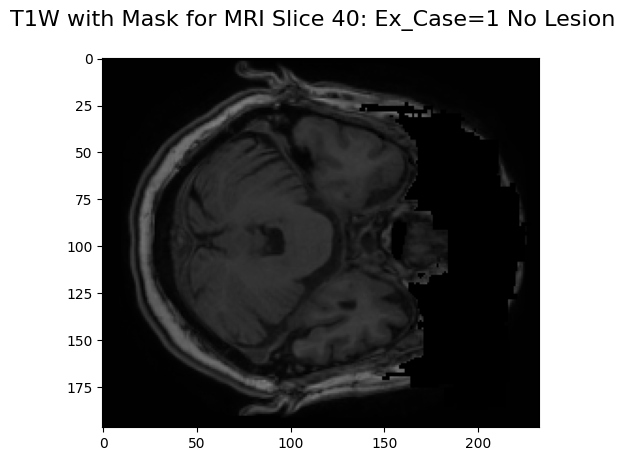

In [26]:
fig = plt.figure()

# show T1W image with overlayed mask; 
# slice 2 show from set of MRI slices; 
# lesion segmentation masks dont show up in all MRI slices; for ex,
# MRI slice 40 has no lesion mask whereas MRI slice 80 does
slice2show_1=40
plt.imshow(t1w_image[:,:,slice2show_1], cmap='gray')
plt.imshow(mask_image[:,:,slice2show_1], alpha=0.5, cmap='copper')
fig.suptitle('T1W with Mask for MRI Slice 40: Ex_Case={} No Lesion'.format(example_case), fontsize=16)

plt.show()

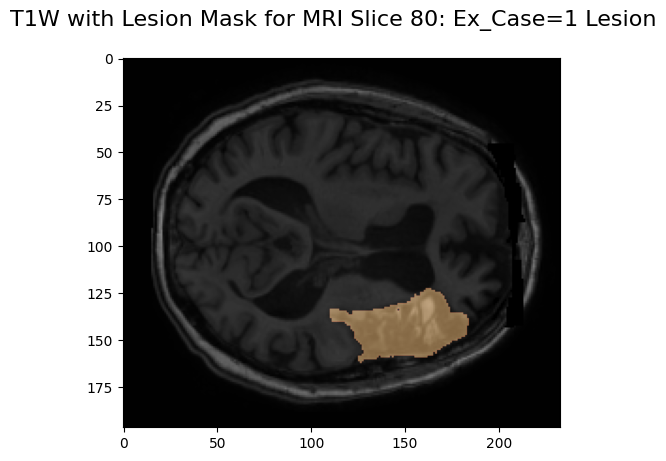

In [27]:
fig = plt.figure()

# show T1W image with overlayed mask; 
# slice 2 show from set of MRI slices; 
# lesion segmentation masks dont show up in all MRI slices; for ex,
# MRI slice 40 has no lesion mask whereas MRI slice 80 does
slice2show_2=80
plt.imshow(t1w_image[:,:,slice2show_2], cmap='gray')
plt.imshow(mask_image[:,:,slice2show_2], alpha=0.5, cmap='copper')
fig.suptitle('T1W with Lesion Mask for MRI Slice 80: Ex_Case={} Lesion'.format(example_case), fontsize=16)

plt.show()

### Segment T1W using 99th percentile cutoff

In [25]:
# The 99th percentile cutoff for t1w segmentation is done on 
# all slices of the 3D T1W MRI voxel
t1w_cutoff = np.percentile(t1w_image[t1w_image>0], 99) 
segmented_image = t1w_image > t1w_cutoff

### Visualize Segmentation 99th % cutoff Prediction vs Ground Truth on MRI Slice 40

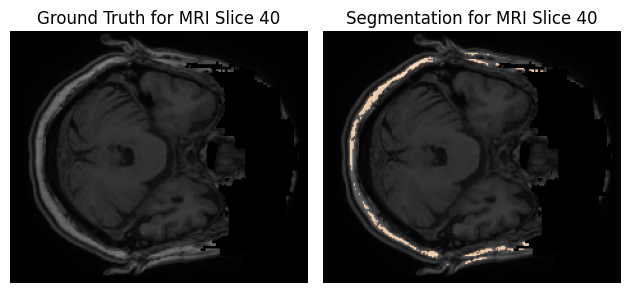

In [28]:
# We'll visualize the 99th percentile cutoff segmentation we've created
# We'll also show the ground truth based on the previous MRI plot

fig2, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(t1w_image[:,:,slice2show_1], cmap='gray')
ax1.imshow(mask_image[:,:,slice2show_1], alpha=0.5, cmap='copper')
ax1.set_title('Ground Truth for MRI Slice 40')
ax1.set_axis_off()

# Show 99th % cutoff predicted segmentation
ax2.imshow(t1w_image[:,:,slice2show_1], cmap='gray')
ax2.imshow(segmented_image[:,:,slice2show_1], alpha=0.5, cmap='copper')
ax2.set_title('Segmentation for MRI Slice 40')
ax2.set_axis_off()
plt.tight_layout()
plt.show()

### Visualize Segmentation 99th % cutoff Prediction vs Ground Truth on MRI Slice 80

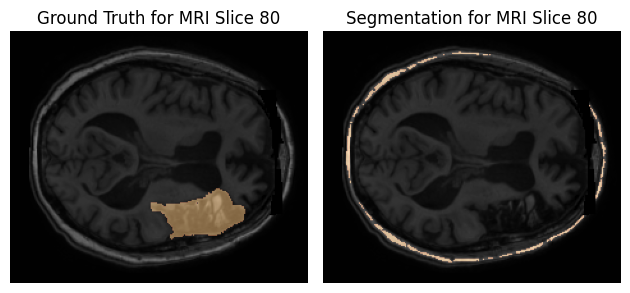

In [29]:
# We'll visualize the 99th percentile cutoff segmentation we've created
# We'll also show the ground truth based on the previous MRI plot

fig3, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(t1w_image[:,:,slice2show_2], cmap='gray')
ax1.imshow(mask_image[:,:,slice2show_2], alpha=0.5, cmap='copper')
ax1.set_title('Ground Truth for MRI Slice 80')
ax1.set_axis_off()

# Show 99th % cutoff predicted segmentation
ax2.imshow(t1w_image[:,:,slice2show_2], cmap='gray')
ax2.imshow(segmented_image[:,:,slice2show_2], alpha=0.5, cmap='copper')
ax2.set_title('Segmentation for MRI Slice 80')
ax2.set_axis_off()
plt.tight_layout()
plt.show()

### Compute Performance Metrics for 3D MRI Voxel Data

We compute performance matrics (Dice score, Voxel volume, count difference, f1-score) between 3D mask voxel, 3D segmentation voxel and 3D T1W MRI voxel data.

In [30]:
# Compute performance metrics.
# Compute dice on 3D Mask Voxel and 3D Segmentation Voxel
print('3D T1W MRI Voxel Dice score: {}'.format(eval_utils.compute_dice(mask_image, segmented_image)))

# Compute absolute volume difference for 3D T1W MRI Voxel
voxel_volume = np.prod(nib.load(t1w_path).header.get_zooms())/1000 # Get voxel volume
print('Absolute 3D T1W MRI Voxel volume difference: {} ml'.format(eval_utils.compute_absolute_volume_difference(mask_image, segmented_image, voxel_volume)))

# Compute absolute lesion count difference
print('Absolute 3D T1W MRI Voxel lesion count difference: {} '.format(eval_utils.compute_absolute_lesion_difference(mask_image, segmented_image)))

# Compute F1-score (lesion-wise)
print('3D T1W MRI Voxel Lesion-wise F1-score: {} '.format(eval_utils.compute_lesion_f1_score(mask_image, segmented_image)))

3D T1W MRI Voxel Dice score: 0.00036230946404078567
Absolute 3D T1W MRI Voxel volume difference: 31.697000000000003 ml
Absolute 3D T1W MRI Voxel lesion count difference: 507 
3D T1W MRI Voxel Lesion-wise F1-score: 0.003929273084479371 


The performance metrics results above make sense. As we can see from the MRI slices (40 and 80) above for each case where the ground truth versus segmentation prediction, the 99th percentil cutoff segmentation prediction was far off from the ground truth segmentation mask in the case of MRI slice 80.

## NLP Clinical Metadata Per 3D MRI Voxel Based Data Exploration

Will add the NLP clinical metadata data exploration next...